In [1]:
!pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4        

- retrieval model, predicts a set of movies from the catalogue that the user is likely to watch
- implicit data

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann

     |████████████████████████████████| 85 kB 2.7 MB/s 
     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 10.6 MB 5.1 MB/s 
     |████████████████████████████████| 458.3 MB 11 kB/s 
     |████████████████████████████████| 5.6 MB 37.5 MB/s 
     |████████████████████████████████| 462 kB 46.4 MB/s 
     |████████████████████████████████| 1.3 MB 78.0 MB/s 


In [ ]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

In [ ]:
import tensorflow_recommenders as tfrs

In [ ]:
# Ratings data.
ratings = tfds.load("movielens/100k-ratings", split="train")
# Features of all the available movies.
movies = tfds.load("movielens/100k-movies", split="train")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling movielens-train.tfrecord...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling movielens-train.tfrecord...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.0. Subsequent calls will reuse this data.




### Data preparation

In [ ]:
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
})
movies = movies.map(lambda x: x["movie_title"])

### Split data

In [ ]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
train = shuffled.take(80000)
test = shuffled.skip(80000).take(20000)

In [ ]:
len(train), len(test)

(80000, 20000)

### Params

In [ ]:
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

unique_movie_titles[:10]

array([b"'Til There Was You (1997)", b'1-900 (1994)',
       b'101 Dalmatians (1996)', b'12 Angry Men (1957)', b'187 (1997)',
       b'2 Days in the Valley (1996)',
       b'20,000 Leagues Under the Sea (1954)',
       b'2001: A Space Odyssey (1968)',
       b'3 Ninjas: High Noon At Mega Mountain (1998)',
       b'39 Steps, The (1935)'], dtype=object)

In [ ]:
len(unique_movie_titles), len(unique_user_ids)

(1664, 943)

### Model

In [ ]:
class MovielensModel(tfrs.Model):

  def __init__(self, unique_user_ids, unique_movie_titles, task, embedding_dimension = 32):
    super().__init__()
    self.embedding_dimension = embedding_dimension
    self.unique_movie_titles = unique_movie_titles
    self.unique_user_ids = unique_user_ids
    self.task: tf.keras.layers.Layer = task
    self.user_model = tf.keras.Sequential([tf.keras.layers.StringLookup(vocabulary = self.unique_user_ids, mask_token=None),
                                           tf.keras.layers.Embedding(len(self.unique_user_ids) + 1, self.embedding_dimension)])
    self.movie_model = tf.keras.Sequential([tf.keras.layers.StringLookup(vocabulary = self.unique_movie_titles, mask_token=None),
                                            tf.keras.layers.Embedding(len(self.unique_movie_titles) + 1, self.embedding_dimension)])

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    user_embeddings = self.user_model(features["user_id"])
    positive_movie_embeddings = self.movie_model(features["movie_title"])

    return self.task(user_embeddings, positive_movie_embeddings)

In [ ]:
metrics = tfrs.metrics.FactorizedTopK(
  candidates=movies.batch(128).map(movie_model)
)

In [ ]:
task = tfrs.tasks.Retrieval(
  metrics=metrics
)

In [ ]:
model = MovielensModel(unique_user_ids, unique_movie_titles, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [ ]:
cached_train = train.shuffle(100000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [ ]:
history = model.fit(cached_train, epochs = 3)

Epoch 1/3
10/10 [==============================] - 26s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.3173 - factorized_top_k/top_5_categorical_accuracy: 0.4109 - factorized_top_k/top_10_categorical_accuracy: 0.4542 - factorized_top_k/top_50_categorical_accuracy: 0.5751 - factorized_top_k/top_100_categorical_accuracy: 0.6421 - loss: 65625.8210 - regularization_loss: 0.0000e+00 - total_loss: 65625.8210
Epoch 2/3
10/10 [==============================] - 29s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.3374 - factorized_top_k/top_5_categorical_accuracy: 0.4311 - factorized_top_k/top_10_categorical_accuracy: 0.4739 - factorized_top_k/top_50_categorical_accuracy: 0.5965 - factorized_top_k/top_100_categorical_accuracy: 0.6621 - loss: 65127.0199 - regularization_loss: 0.0000e+00 - total_loss: 65127.0199
Epoch 3/3
10/10 [==============================] - 27s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.3509 - factorized_top_k/top_5_categorical_accuracy: 0.4452

### Evaluate

In [ ]:
history.history

{'factorized_top_k/top_100_categorical_accuracy': [0.6421124935150146,
  0.6620875000953674,
  0.6748124957084656],
 'factorized_top_k/top_10_categorical_accuracy': [0.45416250824928284,
  0.47386249899864197,
  0.48801249265670776],
 'factorized_top_k/top_1_categorical_accuracy': [0.31728750467300415,
  0.33739998936653137,
  0.3509249985218048],
 'factorized_top_k/top_50_categorical_accuracy': [0.5751374959945679,
  0.5965499877929688,
  0.6108250021934509],
 'factorized_top_k/top_5_categorical_accuracy': [0.4108999967575073,
  0.43114998936653137,
  0.4452125132083893],
 'loss': [51009.5390625, 50677.5390625, 50413.59765625],
 'regularization_loss': [0, 0, 0],
 'total_loss': [51009.5390625, 50677.5390625, 50413.59765625]}

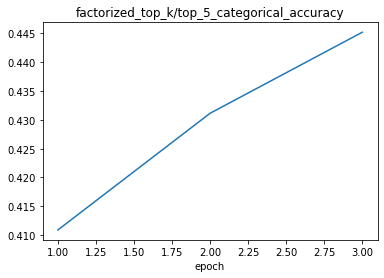

In [ ]:
plt.plot(range(1,4,1), history.history['factorized_top_k/top_5_categorical_accuracy'])
plt.xlabel('epoch')
plt.title('factorized_top_k/top_5_categorical_accuracy')
plt.show()

In [ ]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 9s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.2375 - factorized_top_k/top_5_categorical_accuracy: 0.3194 - factorized_top_k/top_10_categorical_accuracy: 0.3580 - factorized_top_k/top_50_categorical_accuracy: 0.4740 - factorized_top_k/top_100_categorical_accuracy: 0.5425 - loss: 31083.8555 - regularization_loss: 0.0000e+00 - total_loss: 31083.8555


{'factorized_top_k/top_100_categorical_accuracy': 0.5424500107765198,
 'factorized_top_k/top_10_categorical_accuracy': 0.35804998874664307,
 'factorized_top_k/top_1_categorical_accuracy': 0.2374500036239624,
 'factorized_top_k/top_50_categorical_accuracy': 0.4740000069141388,
 'factorized_top_k/top_5_categorical_accuracy': 0.31940001249313354,
 'loss': 28256.5390625,
 'regularization_loss': 0,
 'total_loss': 28256.5390625}

### Predict

In [ ]:
scann_index = tfrs.layers.factorized_top_k.ScaNN(model.user_model)
scann_index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

In [ ]:
%%time
# Get recommendations.
_, titles = scann_index(tf.constant(["101"]), 10)
print(f"Recommendations for user 101: {titles[0, :3]}")

Recommendations for user 101: [b'Associate, The (1996)' b'Fled (1996)' b'Very Brady Sequel, A (1996)']
CPU times: user 6.65 ms, sys: 0 ns, total: 6.65 ms
Wall time: 6.74 ms


In [ ]:
# Export the query model.
with tempfile.TemporaryDirectory() as tmp:
  path = os.path.join(tmp, "model")

  # Save the index.
  tf.saved_model.save(
      scann_index,
      path,
      options=tf.saved_model.SaveOptions(namespace_whitelist=["Scann"])
  )

  # Load it back; can also be done in TensorFlow Serving.
  loaded = tf.saved_model.load(path)

  # Pass a user id in, get top predicted movie titles back.
  scores, titles = loaded(["101"])

  print(f"Recommendations: {titles[0][:3]}")

INFO:tensorflow:Assets written to: /tmp/tmpqh9k1lr9/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpqh9k1lr9/model/assets


Recommendations: [b'Associate, The (1996)' b'Fled (1996)' b'Very Brady Sequel, A (1996)']
